In [1]:
# import widen_notebook
from mysetup import NotebookFinder
import sys
sys.meta_path.append(NotebookFinder())

from setup_transform import *
%matplotlib inline
cl_weight = sklearn.utils.compute_class_weight(class_weight='balanced',classes=[0,1,2],y=y)
CLASS_WEIGHTS = {i:cl_weight[i] for i in range(3)}    
def_cv = RepeatedStratifiedKFold(n_splits=3,n_repeats=5,random_state=42)
lgr_params = dict(class_weight=CLASS_WEIGHTS,fit_intercept=False,multi_class='ovr',max_iter=2000000,random_state=42,n_jobs=24, penalty ='elasticnet' ,cv=def_cv,scoring='f1_macro',solver='saga',Cs=100,l1_ratios= np.linspace(0,1,endpoint=False,num=100))
from sklearnex import unpatch_sklearn
# unpatch_sklearn()
import copy
import warnings
warnings.filterwarnings('ignore')

importing Jupyter notebook from setup_transform.ipynb


Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
import copy
discrete_ordinal = copy.deepcopy(ordinal)
discrete_ordinal.remove('ordinal__norm')

In [2]:
from scipy.stats import chi2_contingency
import numpy as np
def cramer(data_df, varfs):
    data_encoded = pd.DataFrame() 

    for i in varfs +['target']:
        data_encoded[i]= data_df[i]



    def cramers_V(var1,var2) :
        crosstab =np.array(pd.crosstab(var1,var2, rownames=None, colnames=None)) # Cross table building
        stat = chi2_contingency(crosstab)[0] # Keeping of the test statistic of the Chi2 test
        obs = np.sum(crosstab) # Number of observations
        mini = min(crosstab.shape)-1 # Take the minimum value between the columns and the rows of the cross table
        return (stat/(obs*mini))



    rows= []

    for var1 in data_encoded:
        col = []
        for var2 in data_encoded :
            cramers =cramers_V(data_encoded[var1], data_encoded[var2]) # Cramer's V test
            col.append(round(cramers,2)) # Keeping of the rounded value of the Cramer's V  
        rows.append(col)

    cramers_results = np.array(rows)
    df = pd.DataFrame(cramers_results, columns = data_encoded.columns, index =data_encoded.columns)


    return df.target.iloc[:-1]

In [2]:
# X_dn.loc[:,nominal].unique()
"""
Omit Unseen Categories and set them to zero
"""
X_dn = raw_data.copy()
X_dn_eval  = raw_data_eval.copy()
omit_nominal = {x:[] for x in nominal}
for c in nominal:
    unq_train = raw_data[c].unique()    
    unq_eval = raw_data_eval[c].unique()
    uni = np.union1d(unq_train,unq_eval)
    inter = np.intersect1d(unq_train,unq_eval)
    omit_nominal[c] = list(np.setdiff1d(uni,inter,assume_unique=True))

def omit_nom(row):
    for c in nominal:
        if row[c] in omit_nominal[c]:
            row[c] = 0
    return row
X_dn = X_dn.apply(omit_nom,axis=1)
X_dn_eval = X_dn_eval.apply(omit_nom,axis=1)

X_master = pd.concat([X_dn.loc[:,X_dn_eval.columns],X_dn_eval],ignore_index=True,axis=0)
"""
Find Lowest Slot for infrequent Values
"""
unique_n = {}
for c in nominal:
    unique_n[c]  = X_master[c].unique().astype('int')

infreq_slot = {x:0 for x in nominal}

for c in unique_n:
    min_c = unique_n[c].min()    
    max_c = unique_n[c].max()
    c_range = np.arange(min_c,max_c,)
    infreq_slot[c] = np.setdiff1d(c_range,unique_n[c]).min()
    
"""
Find Lowest Infrequency Threshold
"""
vc_train = {x:X_dn[x].value_counts().to_dict() for x in nominal}
vc_eval = {x:X_dn_eval[x].value_counts().to_dict() for x in nominal}
infreq_threshold = {'train':{},'eval': {}}
f2 = 0.0
f1 = 0.006
for c in nominal:

    Tfreqs1 = list(vc_train[c].values())
    Tfreqs1 = sorted(set(Tfreqs1))
    infreq_threshold['train'][c] = Tfreqs1[12]
    if '12' in c or '21' in c:
        infreq_threshold['train'][c] = Tfreqs1[3]
        

        
    Tfreqs2 = list(vc_eval[c].values())
#     Tfreqs2 = sorted(Tfreqs2)
    Tfreqs2 = sorted(set(Tfreqs2))
    infreq_threshold['eval'][c] = Tfreqs2[6]
    if '12' in c or '21' in c or '4' in c:
        infreq_threshold['eval'][c] = Tfreqs2[3]

train_infreq = {x:[] for x in nominal}
eval_infreq = {x:[] for x in nominal}
selected_infreq = {x:[] for x in nominal}


"""
Find Infrequent Categories
"""

for c in nominal:
    for k in vc_train[c]:
#         if vc_train[c][k] < infreq_threshold['train'][c]:
        if vc_train[c][k] < 9:
            train_infreq[c].append(k)
    for k in vc_eval[c]:
#         if vc_eval[c][k] < infreq_threshold['eval'][c]:
        if vc_eval[c][k] < 3:
            eval_infreq[c].append(k)

for c in nominal:
    cmmn_infreq = train_infreq[c]
    selected_infreq[c] = list(cmmn_infreq)
    
def mark_infreq_nom(row):
    for c in nominal:
        if row[c] in selected_infreq[c]:
            row[c] = infreq_slot[c]
    return row

X_dn = X_dn.apply(mark_infreq_nom,axis=1)
X_dn_eval = X_dn_eval.apply(mark_infreq_nom,axis=1)
def ohe(df):
    return pd.get_dummies(df.loc[:,nominal],columns=nominal)
vt = VarianceThreshold()
print(mutual_info_classif(vt.fit_transform(ohe(X_dn)),raw_data.target, random_state=42,discrete_features=True).mean() - mutual_info_classif(vt.fit_transform(ohe(raw_data)),raw_data.target, random_state=42,discrete_features=True).mean())

infreq_threshold

0.00035172395068976147


{'train': {'nominal__v_12': 9,
  'nominal__v_18': 14,
  'nominal__v_20': 15,
  'nominal__v_21': 11,
  'nominal__v_25': 15,
  'nominal__v_3': 13,
  'nominal__v_32': 14,
  'nominal__v_4': 13},
 'eval': {'nominal__v_12': 6,
  'nominal__v_18': 7,
  'nominal__v_20': 7,
  'nominal__v_21': 6,
  'nominal__v_25': 7,
  'nominal__v_3': 7,
  'nominal__v_32': 7,
  'nominal__v_4': 4}}

In [11]:
"""
Min Samples with all Categories
"""
discrete_ordinal = copy.deepcopy(ordinal)
discrete_ordinal.remove('ordinal__norm')
X = X_dn.loc[:,nominal+discrete_ordinal]
cat_idx = {c:{} for c in nominal+discrete_ordinal}
for c in nominal+discrete_ordinal:
    categories = X[c].unique()
    for ca in categories:
        cat_idx[c][ca] = X[X[c]==ca].index
    # for c_ in discrete_ordinal:
from numpy.random import default_rng
def gen_rand_unique_idx(cat_idx):
    dfe1 = default_rng()
    m_idx = set()
    for c in cat_idx:
        for k,v in cat_idx[c].items():
            dfe = default_rng(seed=dfe1.integers(0,dfe1.integers(0,2121231212)))
            _ = dfe.choice(v,replace=False)
            # for e_ in _:
            m_idx.add(_)
    return m_idx
fin_idx = gen_rand_unique_idx(cat_idx)
for _ in range(500):
    tmp = gen_rand_unique_idx(cat_idx)
    fin_idx = fin_idx.intersection(tmp)
    
nw_X = X.loc[fin_idx,:]
for c in nominal+discrete_ordinal:
    tot = X[c].unique()
    av = nw_X[c].unique()
    miss = np.setdiff1d(tot,av)
    for m in miss:
        unc = np.setdiff1d(cat_idx[c][m],fin_idx)
        dfe = default_rng()
        ani  =dfe.choice(unc)
        fin_idx.add(ani)
len(fin_idx)


345

In [24]:
other = raw_data.index.difference(fin_idx)
X = pd.get_dummies(X_dn.loc[:,nominal+discrete_ordinal],columns=nominal+discrete_ordinal)
X_train, X_test, y_train,y_test = gen_train_test(X.loc[other,:],y.loc[other],test_size=0.3)
# X_train2, X_valid, y_train2,y_valid = gen_train_test(X_train,y_train,test_size=0.3)

In [26]:
with parallel_backend('threading',n_jobs=24):
    # clf1_ = CategoricalNB(fit_prior=False,alpha=0,min_categories=2)
    # clf1 = OneVsRestClassifier(clf1,n_jobs=-1)
    clf1 =  CategoricalNB(fit_prior=True,alpha=0,min_categories=2)
    clf2_ = ComplementNB(alpha=0.0, fit_prior=True, norm=False)
    clf2  = OneVsRestClassifier(clf2_,n_jobs=-1)
    clf3_  = BernoulliNB(binarize=False,alpha=0,fit_prior=True)
    clf3  = OneVsRestClassifier(clf3_,n_jobs=-1)
    clf4_  = MultinomialNB(alpha=0,fit_prior=True)
    clf4  = OneVsRestClassifier(clf4_,n_jobs=-1)

#     for clf in [clf1,clf2,clf3,clf4]:
        

#         clf.partial_fit(X.loc[fin_idx,:],y.loc[fin_idx],classes=[0,1,2])
#         cv  = RepeatedStratifiedKFold(n_splits=5,n_repeats=20, random_state=42)

#         for train_index, test_index in cv.split(X_train2, y_train2):
#             X_train_, X_test_ = X.loc[train_index,:], X.loc[test_index,:]
#             y_train_, y_test_ = y[train_index], y[test_index]
#             # print(X_train.shape)

#             clf.partial_fit(X_train_,y_train_,classes=[0,1,2])   
#             clf.partial_fit(X_test_,y_test_,classes=[0,1,2])
# #         y_pred = clf.predict(X_test)
# #         print(classification_report(y_test,y_pred))
    estimators = [
    ('cnb',clf1),
    ('comnb',clf2),
    ('bnb',clf3),
    ('mnb',clf4)
    ]
    stc1 = StackingClassifier(estimators=estimators,final_estimator=LogisticRegressionCV(**lgr_params),cv=3,n_jobs=-1)
    stc1.fit(X.loc[fin_idx.union(X_train.index),:],y.loc[fin_idx.union(X_train.index)])
#     stc1.fit(X_train,y_train)
    y_pred = clf.predict(X_test)
    print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.75      0.66      0.70       337
           1       0.81      0.78      0.80       510
           2       0.44      0.57      0.49       189

    accuracy                           0.70      1036
   macro avg       0.67      0.67      0.67      1036
weighted avg       0.72      0.70      0.71      1036



In [ ]:
X1 = ohe(X_dn)
X2 = ohe(raw_data)
y = raw_data.target
logi = LogisticRegressionCV(**lgr_params)
with parallel_backend('loky'):
    s1 = cross_validate(logi,X1,y,cv=def_cv,scoring='f1_macro',n_jobs=24,return_train_score=True)
    s2 = cross_validate(logi,X2,y,cv=def_cv,scoring='f1_macro',n_jobs=24,return_train_score=True)

In [ ]:
print(s1)


In [ ]:
print(s2)

In [184]:
mutual_info_classif(ohe(raw_data),raw_data.target,random_state=42).sum()

2.5707606388648

In [183]:
mutual_info_classif(ohe(X_dn),raw_data.target, random_state=42).sum()

0.4975812101770851

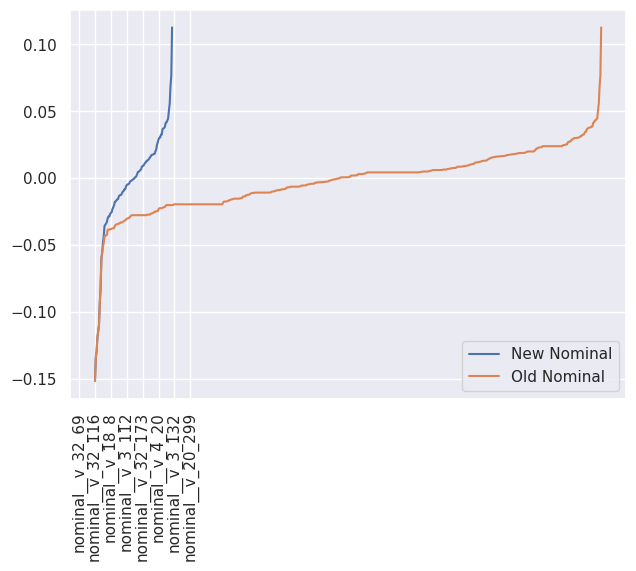

In [131]:
# SpectralClustering
ohe(X_dn).corrwith(raw_data.target,method='kendall').sort_values().plot(rot=90, label='New Nominal')
_ = ohe(raw_data).corrwith(raw_data.target,method='kendall').sort_values().plot(rot=90,label='Old Nominal')

_ = plt.legend()

In [3]:
agg_tc =raw_data.groupby(['nominal__v_18'])['target'].value_counts().unstack().fillna(0).astype(np.uint16).sort_values(by=[1,0,2],ascending=False)
agg_tc

eval_freq  = raw_data_eval.nominal__v_18.value_counts()

agg_tc['eval'] = eval_freq
agg_tc['total_freq'] = agg_tc[0]+agg_tc[1]+agg_tc[2]
agg_tc = agg_tc.fillna(0).astype('int')
tmp: pd.DataFrame = agg_tc[agg_tc['eval'] ==0]
# tmp.filter
tmp
agg_tc[agg_tc['eval'] == 0]

agg_tc[agg_tc['total_freq']<=15]
agg_tc['t_e'] = agg_tc['eval']/agg_tc['total_freq']

# agg_tc[agg_tc['eval']==agg_tc['total_freq']]
agg_tc

target,0,1,2,eval,total_freq,t_e
nominal__v_18,,,,,,
103,332,588,182,510,1102,0.462795
23,176,301,106,252,583,0.432247
30,123,203,79,157,405,0.387654
12,75,132,52,109,259,0.420849
38,58,102,36,94,196,0.479592
...,...,...,...,...,...,...
260,0,0,1,1,1,1.000000
287,0,0,1,0,1,0.000000
316,0,0,1,0,1,0.000000


In [41]:
from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import pairwise_kernels
X = pd.get_dummies(raw_data.loc[:,nominal+discrete_ordinal+binary], columns=nominal+discrete_ordinal)


dist = pairwise_distances(X.to_numpy(), metric='jaccard',force_all_finite=False)


In [45]:
# tree = KDTree(dist,leaf_size=500,metric='euclidean')
tree.get_tree_stats()

(0, 0, 0)

In [50]:
cKe = pairwise_kernels(X,metric='linear',n_jobs=-1)

In [52]:
cKe.shape

(3796, 3796)